In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from Bio import SeqIO
import pprint

### Делаем словарь со списком геномов и словарь белков

In [3]:
genomes_dict = dict()
for genus in os.listdir('data'):
    files = os.listdir('data/'+genus)
    files = list(filter(lambda x: x.endswith('.faa'), files))
    species = list(map(lambda x: x.split(".")[0], files))
    genomes_dict[genus] = species

In [4]:
aa_seqs = dict()
for genus in genomes_dict.keys():
    for genome in genomes_dict[genus]:
        aa_seqs.update(SeqIO.to_dict(SeqIO.parse(f"data/{genus}/{genome}.faa", "fasta")))

In [5]:
# Список всех геномов
genomes_list = []
for key in genomes_dict.keys():
    for genome in genomes_dict[key]:
        genomes_list.append(genome)

## Определяем кластеры

In [14]:
folders = ["data/" + folder + "/*" for folder in os.listdir("data")]
" ".join(folders)

'data/Halomonas/* data/Enterobacter/* data/Mannheimia/* data/Aeromonas/* data/Erwinia/* data/Lysobacter/* data/Klebsiella/* data/Dickeya/* data/Kosakonia/* data/Pseudomonas/*'

In [17]:
subprocess.run("proteinortho5 -project=gammaproteo " + " ".join(folders), shell=True, check=True)

CompletedProcess(args='proteinortho5 -project=gammaproteo data/Halomonas/* data/Enterobacter/* data/Mannheimia/* data/Aeromonas/* data/Erwinia/* data/Lysobacter/* data/Klebsiella/* data/Dickeya/* data/Kosakonia/* data/Pseudomonas/*', returncode=0)

In [18]:
! mv gammaproteo* proteinortho/

## Работаем со статистикой

In [ ]:
clusters = pd.read_csv("proteinortho/gammaproteo.proteinortho", sep='\t')
clusters = clusters.loc[clusters['# Species'] >= 25]
clusters.replace(to_replace='*', value=np.NaN, inplace=True)
clusters

#### Готовим таблицу

In [7]:
def return_function_by_id(ID):
    Seq = aa_seqs[ID]
    descr = Seq.description
    if ":" in descr:
        return descr[descr.find(":")+1 : descr.find("[")].strip().capitalize()
    else:
        return descr[descr.find(" ")+1 : descr.find("[")].strip().capitalize()

return_function_by_id('BBW73724.1')


'Hypothetical protein thokle011_00140'

In [8]:
def return_function_of_cluster(row):
    row = row[3:53]
    row = row.dropna()
    # To deal with multiple genes in one genome
    row = ",".join(row).split(',')
    list_of_functions = list(map(return_function_by_id, row))
    values, counts = np.unique(list_of_functions, return_counts=True)
    return values[np.argmax(counts)]

return_function_of_cluster(clusters.iloc[8])

'50s ribosomal protein l29'

In [9]:
def number_of_genuses(row):
    row = row[3:53]
    row = row.dropna()
    names = list(map(lambda x: x.split('.')[0], row.index))
    counter = 0
    for key in genomes_dict:
        for name in names:
            if name in genomes_dict[key]:
                counter += 1
                break
    return counter

number_of_genuses(clusters.iloc[10])

8

In [10]:
def read_zdna_df(genome):
    zdna = pd.read_csv(f"intersect_bed/{genome}.intersect.bed", sep='\t', 
                names=["Sp1", "St1", "En1", "Protein", "Sp2", "Start", "End", f"Score_{genome}"]
                )[["Protein", f"Score_{genome}", "Start", "End"]]
    zdna.sort_values(f"Score_{genome}", ascending=False, inplace=True)
    # Drop duplicate proteins, keep maximal score
    zdna.drop_duplicates(subset='Protein', inplace=True)
    zdna.set_index("Protein", inplace=True)
    return zdna

In [11]:
# Пересекаем Z-DNA и кластеры

for genome in genomes_list:
    zdna = read_zdna_df(genome)[f"Score_{genome}"]
    list_of_zhscores = []

    for prot in clusters[f"{genome}.faa"]:

        if pd.isnull(prot):
            list_of_zhscores.append(np.NaN)
            continue
        prot_list = prot.split(',')
        if len(prot_list) == 1:
            if prot[0] in list(zdna.index):
                list_of_zhscores.append(float(zdna.loc[prot_list[0]]))
            else:
                list_of_zhscores.append(np.NaN)
        else:
            max_score = 0
            for pr in prot_list:
                if pr in list(zdna.index):
                    max_score = max(max_score, float(zdna.loc[pr]))
            if max_score != 0:
                list_of_zhscores.append(max_score)
            else:
                list_of_zhscores.append(np.NaN)
    clusters[f"{genome}.score"] = list_of_zhscores
clusters.head()

/tmp/ipykernel_272/4076324816.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters[f"{genome}.score"] = list_of_zhscores
/tmp/ipykernel_272/4076324816.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clusters[f"{genome}.score"] = list_of_zhscores


,# Species,Genes,Alg.-Conn.,M_ovis.faa,P_citronellolis.faa,M_granulomatis.faa,M_pernigra.faa,M_bovis.faa,M_haemolytica.faa,L_caseinilyticus.faa,...,E_chengduensis.score,E_oligotrophicus.score,E_sichuanensis.score,E_ludwigii.score,E_soli.score,A_media.score,A_encheleia.score,A_hydrophila.score,A_dhakensis.score,A_caviae.score
1,27,27,1.850,WP_005539416.1,WP_003093734.1,NaN,NaN,NaN,NaN,WP_213435471.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29,29,1.720,WP_005596065.1,WP_009617012.1,NaN,NaN,NaN,WP_006249241.1,WP_027083463.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34,34,1.470,WP_005596075.1,WP_003099086.1,WP_165889142.1,NaN,NaN,WP_006249240.1,WP_036169932.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,28,28,0.611,WP_005599073.1,WP_003457994.1,NaN,NaN,WP_025236987.1,NaN,WP_213437440.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,35,35,1.430,WP_005599322.1,WP_009617178.1,NaN,NaN,NaN,NaN,WP_213435455.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
def return_genes_with_zdna(row):
    row = row[53:103]
    row = row.dropna()
    return len(row)

def return_zdna_max(row):
    row = row[53:103]
    row = row.dropna()
    return np.max(row)

def return_zdna_mean(row):
    row = row[53:103]
    row = row.dropna()
    return np.mean(row)

In [13]:
cluster_stat = pd.DataFrame(clusters[['# Species', 'Genes']])
cluster_stat['Genuses'] = clusters.apply(number_of_genuses, axis=1)
cluster_stat['Genes_with_ZDNA'] = clusters.apply(return_genes_with_zdna, axis=1)
cluster_stat['Max ZH-Score'] = clusters.apply(return_zdna_max, axis=1)
cluster_stat['Mean ZH-Score'] = clusters.apply(return_zdna_mean, axis=1)
cluster_stat['Function'] = clusters.apply(return_function_of_cluster, axis=1)
cluster_stat.sort_values(['Genes_with_ZDNA', '# Species'], ascending=False, inplace=True)
cluster_stat.to_csv("all_cluster_stats.tsv", sep='\t')
cluster_stat

,# Species,Genes,Genuses,Genes_with_ZDNA,Max ZH-Score,Mean ZH-Score,Function
977,50,73,10,18,211093.90,35448.163050,Cysteine desulfurase
1391,48,69,10,18,23787.35,6762.253067,Sec-independent protein translocase subunit tata
208,42,67,10,17,29467.88,3264.725259,P-ii family nitrogen regulator
481,42,75,10,16,9852.15,2899.237737,Hth-type transcriptional repressor purr
560,49,88,10,15,29467.88,11363.642760,Lipoprotein-releasing abc transporter permease...
...,...,...,...,...,...,...,...
6913,25,25,6,0,NaN,NaN,Transporter substrate-binding domain-containin...
7037,25,26,7,0,NaN,NaN,Type ii secretion system minor pseudopilin gsph
7039,25,25,7,0,NaN,NaN,Type ii secretion system minor pseudopilin gspj
7070,25,25,7,0,NaN,NaN,Methionine synthase


#### Рисуем гистограмму распределения родов, видов и генов в кластерах

In [ ]:
! mkdir -p pictures
sns.set_theme()
sns.histplot(data=clusters, x="# Species", discrete=True)
plt.title("Distribution of species in clusters")
plt.tight_layout()
plt.savefig(f"pictures/species_distribution.png", dpi=400)
plt.close()

sns.histplot(data=clusters, x="Genes", discrete=True)
plt.title("Distribution of genes in clusters")
plt.tight_layout()
plt.savefig(f"pictures/genes_distribution.png", dpi=400)
plt.close()

sns.histplot(data=cluster_stat, x="Genuses", discrete=True)
plt.title("Distribution of genuses in clusters")
plt.tight_layout()
plt.savefig(f"pictures/genuses_distribution.png", dpi=400)
plt.close()

### Выбираем 5 кластеров с Z-DNA в промоторе и рисуем карту

In [296]:
chosen = clusters.dropna(subset=clusters.columns[-50:], thresh=14)
chosen.set_index(pd.Index(range(1, len(chosen)+1)), inplace=True)
chosen

,# Species,Genes,Alg.-Conn.,M_ovis.faa,P_citronellolis.faa,M_granulomatis.faa,M_pernigra.faa,M_bovis.faa,M_haemolytica.faa,L_caseinilyticus.faa,...,E_chengduensis.score,E_oligotrophicus.score,E_sichuanensis.score,E_ludwigii.score,E_soli.score,A_media.score,A_encheleia.score,A_hydrophila.score,A_dhakensis.score,A_caviae.score
1,44,61,0.177,WP_159628559.1,WP_009617794.1,WP_165889518.1,NaN,WP_025216575.1,WP_006249539.1,WP_213433771.1,...,1309.834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,42,67,0.114,WP_159628689.1,"WP_009622545.1,WP_003457590.1","WP_165888676.1,WP_027073914.1",WP_176807709.1,WP_025236863.1,WP_006249991.1,WP_213437086.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,42,75,0.152,"WP_159629128.1,WP_159630056.1",WP_237143049.1,"WP_165888754.1,WP_165888445.1","WP_176808502.1,WP_176807464.1","WP_188157416.1,WP_188156386.1","WP_006248949.1,WP_006249850.1",WP_213434935.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9852.15
4,49,88,0.125,"WP_159629262.1,WP_192919075.1","WP_043267283.1,WP_009621388.1","WP_165888260.1,WP_165888262.1","WP_176808027.1,WP_176808029.1","WP_188156736.1,WP_188156734.1","WP_006249576.1,WP_006249574.1",WP_213434421.1,...,NaN,NaN,8485.7560,8485.7560,NaN,NaN,NaN,NaN,NaN,NaN
5,44,69,0.103,WP_159630519.1,WP_061560673.1,WP_165888610.1,WP_176808709.1,WP_188156570.1,WP_006253460.1,NaN,...,NaN,NaN,844.2485,NaN,NaN,1403.277,NaN,NaN,NaN,NaN
6,50,73,0.112,WP_159630612.1,WP_061562514.1,WP_165889137.1,WP_176808743.1,WP_188156604.1,WP_006249213.1,WP_213433824.1,...,NaN,NaN,NaN,883.5764,NaN,NaN,NaN,NaN,NaN,NaN
7,48,69,0.101,WP_159628569.1,WP_043315140.1,WP_165889526.1,WP_176807406.1,WP_188157006.1,WP_006249493.1,WP_213436741.1,...,NaN,NaN,NaN,6017.9190,23787.35,NaN,NaN,NaN,NaN,NaN


In [297]:
heat_df = chosen.iloc[:, 53:103]
heat_df

,H_chromatireducens.score,H_aestuarii.score,H_elongatae.score,H_socia.score,H_beimenensis.score,E_persicina.score,E_billingiae.score,E_tasmaniensis.score,E_pyrifoliae.score,E_gerundensis.score,...,E_chengduensis.score,E_oligotrophicus.score,E_sichuanensis.score,E_ludwigii.score,E_soli.score,A_media.score,A_encheleia.score,A_hydrophila.score,A_dhakensis.score,A_caviae.score
1,NaN,NaN,NaN,NaN,NaN,NaN,28780.5000,1309.8340,2197.6460,4914.1460,...,1309.834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,883.5764,NaN,2752.447,766.6232,NaN,980.8116,766.6232,783.8230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1228.7200,NaN,883.5764,3403.0510,883.5764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9852.15
4,NaN,NaN,NaN,NaN,NaN,3700.9720,NaN,3700.9720,3700.9720,572.5964,...,NaN,NaN,8485.7560,8485.7560,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,844.2485,NaN,NaN,1403.277,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,883.5764,826.8355,883.5764,211093.9000,904.3200,...,NaN,NaN,NaN,883.5764,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,3428.5290,NaN,3428.5290,3428.5290,NaN,...,NaN,NaN,NaN,6017.9190,23787.35,NaN,NaN,NaN,NaN,NaN


In [301]:
for i, row in heat_df.iterrows():
    for genome in genomes_list:
        # Если есть ген-ортолог и НЕТ zdna, красим в белый -> NaN
        if not pd.isnull(chosen.loc[i, genome+'.faa']) and (pd.isnull(chosen.loc[i, genome+'.score'])):
            pass
        # Нет гена-ортолога
        elif pd.isnull(chosen.loc[i, genome+'.faa']):
            row.loc[genome+'.score'] = 0.0

heat_df_T = heat_df.T

In [ ]:
cmap = matplotlib.cm.get_cmap("YlOrBr").copy()
cmap.set_under('#7c9184')
fig, ax = plt.subplots(figsize=(12, 16))
annotation = heat_df_T.applymap(lambda x: int(x), na_action='ignore').replace(0, '')
sns.heatmap(heat_df_T, vmax = 10000, vmin=500, cmap=cmap, 
            mask=heat_df_T.isnull(), ax=ax, 
            annot=annotation, fmt=''
            )
plt.title("Heatmap of Z-DNA in clusters")
plt.tight_layout()
plt.savefig("pictures/heatmap_with_annotation", dpi=350)

### Функции кластеров

In [325]:
for i, row in chosen.iterrows():
    print("Кластер №"+str(i))
    print(return_function_of_cluster(row))
    print()

Кластер №1
Pts phosphocarrier protein npr

Кластер №2
P-ii family nitrogen regulator

Кластер №3
Hth-type transcriptional repressor purr

Кластер №4
Lipoprotein-releasing abc transporter permease subunit lole

Кластер №5
Molybdopterin-synthase adenylyltransferase moeb

Кластер №6
Cysteine desulfurase

Кластер №7
Sec-independent protein translocase subunit tata



**Выберем кластер 4**

### Готовим выравнивания

#### Аминокислотное

In [333]:
return_function_of_cluster(chosen.loc[4])

'Lipoprotein-releasing abc transporter permease subunit lole'

In [340]:
chosen_row = chosen.loc[4]
chosen_row

# Species                                         49
Genes                                             88
Alg.-Conn.                                     0.125
M_ovis.faa             WP_159629262.1,WP_192919075.1
P_citronellolis.faa    WP_043267283.1,WP_009621388.1
                                   ...              
A_media.score                                    NaN
A_encheleia.score                                NaN
A_hydrophila.score                               NaN
A_dhakensis.score                                NaN
A_caviae.score                                   NaN
Name: 4, Length: 103, dtype: object

In [345]:
seen = set()
seqs_in_row = []
for genome in genomes_list:
    protein_ids = chosen_row[f"{genome}.faa"]
    if pd.isnull(protein_ids):
        continue
    else:
        protein_ids = protein_ids.split(',')
    for protein_id in protein_ids:
        Seq = aa_seqs[protein_id]
        if Seq.id not in seen:
            seqs_in_row.append(Seq)
            seen.add(Seq.id)
SeqIO.write(seqs_in_row, f"data/raw_cluster_4.faa", "fasta")


88

In [ ]:
os.system(f"clustalw -align -type=PROTEIN -infile='data/raw_cluster_4.faa' -OUTFILE='data/cluster_4_protein.aln'")
! rm -rf data/*.dnd

#### Нуклеотидное

In [360]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [349]:
def choose_max_seq(genus, genome):
    seqs = [str(seq_record.seq) for seq_record in SeqIO.parse(f"data/{genus}/{genome}_genomic.fna", "fasta")]
    # Choose complete genome, remove plasmids
    max_scaffold = max(seqs, key=len)
    return max_scaffold

na_seqs = dict()
for genus in genomes_dict.keys():
    for genome in genomes_dict[genus]:
        na_seqs[genome] = choose_max_seq(genus, genome)

In [365]:
seqs_in_row = []
for genome in genomes_list:
    zdna = read_zdna_df(genome)
    counter = 1
    if not genome+".faa" in chosen_row.dropna():
        continue
    else:
        protein_ids = chosen_row[f"{genome}.faa"]
        protein_ids = protein_ids.split(',')

    for protein_id in protein_ids:
        if protein_id in zdna.index:
            start = zdna.loc[protein_id, "Start"]
            end = zdna.loc[protein_id, "End"]
            if start > end:
                print("ERROR")

            seq = Seq(na_seqs[genome][start:end+1])
            seq_r = SeqRecord(seq, id=f"{genome},seq{counter}")
            counter += 1
            seqs_in_row.append(seq_r)
SeqIO.write(seqs_in_row, f"data/raw_cluster_4.fna", "fasta")


21

In [366]:
os.system(f"clustalw -align -type=DNA -infile='data/raw_cluster_4.fna' -OUTFILE='data/cluster_4_na.aln'")
! rm -rf data/*.dnd




 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence type explicitly set to DNA
Sequence format is Pearson
Sequence 1: H_chromatireducens_seq1    15 bp
Sequence 2: H_aestuarii_seq1           15 bp
Sequence 3: H_beimenensis_seq1          9 bp
Sequence 4: E_persicina_seq1           17 bp
Sequence 5: E_tasmaniensis_seq1        19 bp
Sequence 6: E_tasmaniensis_seq2        13 bp
Sequence 7: E_pyrifoliae_seq1          20 bp
Sequence 8: E_gerundensis_seq1         13 bp
Sequence 9: K_sacchari_seq1            17 bp
Sequence 10: K_pseudosacchari_seq1      17 bp
Sequence 11: K_oryzae_seq1              14 bp
Sequence 12: K_cowanii_seq1             16 bp
Sequence 13: K_radicincitans_seq1       15 bp
Sequence 14: L_antibioticus_seq1        14 bp
Sequence 15: L_capsici_seq1             13 bp
Sequence 16: K_huaxiensis_seq1          19 bp
Sequence 17: K_oxytoca_seq1             17 bp
Sequence 18: K_michiganensis_seq1       19 bp
Sequence 19: K_aerogenes_seq1           22 bp
Sequence 20: E_sichuanens

### Визуализируем Z-ДНК

In [374]:
from dna_features_viewer import GraphicFeature, GraphicRecord

In [371]:
pic_list = ['E_persicina', 'K_pseudosacchari', 'K_oxytoca', 'E_ludwigii']

In [376]:
features_dict = dict()

for genome in pic_list:
    for genus in genomes_dict.keys():
        if genome in genomes_dict[genus]:
            break
    features = pd.read_csv(f"data/{genus}/{genome}_feature_table.txt", sep='\t')
    features = features.loc[
        (features['seq_type']=='chromosome')
    ]
    locuses = list(np.unique(features.locus_tag))
    df = features.copy()

    counter = 1
    for locus in locuses:
        prod = list(features['product_accession'].loc[features.locus_tag == locus].dropna())
        if prod == []:
            prod = ["RNA" + str(counter)]
            counter += 1
            df['product_accession'].loc[df.locus_tag == locus] = prod[0]
        elif len(prod) == 1:
            df['product_accession'].loc[df.locus_tag == locus] = prod[0]
        else:
            print(prod)
    df = df.loc[df['# feature'] == 'gene']
    df = df[["# feature", "class" , "start", "end", "strand", "product_accession", "locus_tag"]]
    features_dict[genome] = df

In [378]:
zdna_dict = dict()
for genome in pic_list:
    features_dict[genome].set_index("product_accession", drop=False, inplace=True)
    zdna_dict[genome] = read_zdna_df(genome)

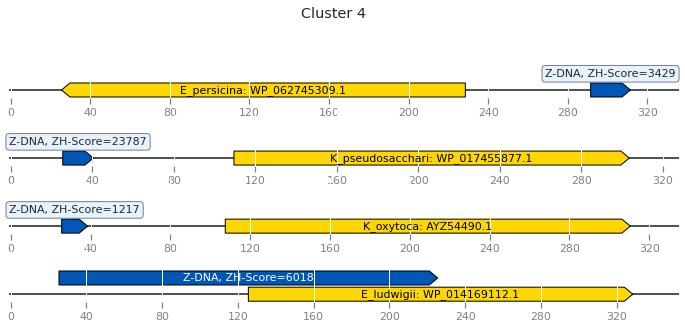

In [395]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(12, 6*4/5))
fig.suptitle(f'Cluster 4')

for i, genome in enumerate(pic_list):
    zdna = zdna_dict[genome]
    features = features_dict[genome]

    prots = row.loc[genome + '.faa']
    prots = prots.split(',')
    
    z_coords, p_coords = [], []
    gr_features = []
    for prot in prots:
        if prot in zdna.index:
            z_coords.append(zdna.loc[prot, "Start"])
            z_coords.append(zdna.loc[prot, "End"])
            p_coords.append(features.loc[prot, "start"])
            p_coords.append(features.loc[prot, "end"])
            strand = +1 if features.loc[prot, "strand"]=="+" else -1
            minimum = min(min(z_coords, p_coords))
            Z_DNA_label = "Z-DNA, ZH-Score=" + str(round(zdna.loc[prot][f"Score_{genome}"]))
            gr_features.append(
                GraphicFeature(start=z_coords[0]-minimum+26, end=z_coords[1]-minimum+26, 
                        strand=+1, color="#0057b8", label=Z_DNA_label))
            gr_features.append(
                GraphicFeature(start=p_coords[0]-minimum+26, end=p_coords[1]-minimum+26, 
                        strand=strand, color="#ffd700", label=genome + ": " + prot))
    record = GraphicRecord(sequence_length=max(max(z_coords, p_coords))-minimum+50, features=gr_features)
    record.plot(ax=axes[i])
plt.savefig(f'pictures/Cluster_and_zdna.png', dpi=500)


## Квадруплексы

In [ ]:
! Rscript configure.r

In [20]:
def choose_max_seq(genome):
    seqs = [str(seq_record.seq) for seq_record in SeqIO.parse(f"data/{genus}/{genome}_genomic.fna", "fasta")]
    # Choose complete genome, remove plasmids
    max_scaffold = max(seqs, key=len)
    return max_scaffold

na_seqs = dict()
for genus in genomes_dict.keys():
    for genome in genomes_dict[genus]:
        na_seqs[genome] = choose_max_seq(genome)

In [21]:
import os
import subprocess
import tempfile
from pathlib import Path
from subprocess import DEVNULL, PIPE

Q_EXECUTABLE = Path("pqsfinder.r")
assert Q_EXECUTABLE.is_file()


def pqs_exec(query: str):
    assert set(query).issubset({"A", "C", "G", "T", "N"})
    fd, temp = tempfile.mkstemp()
    os.close(fd)
    with open(temp, 'w') as stream:
        stream.write(">chr\n"+query)

    subprocess.run(
        ["Rscript", Q_EXECUTABLE, temp, temp + ".qgrs"],
        check=True, stdout=PIPE, stderr=DEVNULL,
        input=query, encoding='ascii'
    )
    
    with open(temp + ".qgrs", 'r') as stream:
        df = pd.read_csv(stream,
                         #names=['ID', 'T1', 'T2', 'T3', 'T4', 'TS', 'GS', 'SEQ'],
                         skiprows=0, sep=' ').iloc[:,:8]
    os.remove(temp)
    os.remove(temp + ".qgrs")
    #df = df.loc[df["score"] > 500]
    #return df
    return df[['start', 'end', 'score', 'strand']]

In [22]:
pqs_dict = dict()
for genome in genomes_list:
    pqs_dict[genome] = pqs_exec(na_seqs[genome])

In [ ]:
sns.set_theme()
for genome in genomes_list:
    sns.histplot(data=pqs_dict[genome], x="score", bins=30, log_scale=False)
    plt.title(genome.replace('_', '. ')+" Quadruplex Scores")
    #plt.savefig(f"pictures/{genome}_quadruplex_distribution.png", dpi=400)
    plt.close()

In [23]:
! mkdir -p pqs_result
for genome in genomes_list:
    pqs_dict[genome].to_csv(f"pqs_result/{genome}.pqs.txt", index=None)

In [24]:
for genome in genomes_list:
    df = pqs_dict[genome].copy()
    bed_df = pd.DataFrame(
        {
            "chrom": [genome] * len(df),
            "chromStart": df.start,
            "chromEnd": df.end,
            "name": df.index,
            "score": df.score,
            "strand": df.strand
        }
    )

    bed_df.to_csv(f"pqs_result/{genome}.pqs.bed", index=None, sep='\t')

In [25]:
for genome in genomes_list:
    os.system(f"bedtools merge -c 5,6 -o max,distinct -i pqs_result/{genome}.pqs.bed > pqs_result/{genome}.pqs.merged.bed")

In [ ]:
features_dict = dict()
for genus in genomes_dict.keys():
    for genome in genomes_dict[genus]:
        features = pd.read_csv(f"data/{genus}/{genome}_feature_table.txt", sep='\t')
        features = features.loc[
            (features['seq_type']=='chromosome')
        ]
        locuses = list(np.unique(features.locus_tag))
        df = features.copy()

        counter = 1
        for locus in locuses:
            prod = list(features['product_accession'].loc[features.locus_tag == locus].dropna())
            if prod == []:
                prod = ["RNA" + str(counter)]
                counter += 1
                df['product_accession'].loc[df.locus_tag == locus] = prod[0]
            elif len(prod) == 1:
                df['product_accession'].loc[df.locus_tag == locus] = prod[0]
            else:
                print(prod)
        df = df.loc[df['# feature'] == 'gene']
        df = df[["# feature", "class" , "start", "end", "strand", "product_accession", "locus_tag"]]
        features_dict[genome] = df

In [28]:
for genome in genomes_list:
    features_dict[genome]['TSS'] = features_dict[genome].apply(lambda x: x.start if x.strand == "+" else x.end, axis=1)

In [29]:
! mkdir -p TSS
for genome in genomes_list:
    df = features_dict[genome].copy()
    bed_df = pd.DataFrame(
        {
            "chrom": [genome] * len(df),
            "chromStart": df.TSS,
            "chromEnd": df.TSS,
            "name": df.product_accession
        }
    )

    bed_df.to_csv(f"TSS/{genome}.bed", index=None, header=None, sep='\t')

In [41]:
pd.DataFrame(
    {
        "Species": genomes_list,
        "Len": [len(na_seqs[genome]) for genome in genomes_list]
    }
).to_csv(f"TSS/my.genomes", index=None, header=None, sep='\t')

In [44]:
for genome in genomes_list:
    os.system(f"bedtools slop -g TSS/my.genomes -i TSS/{genome}.bed -b 100 > TSS/{genome}.slop.bed")
    os.system(f"bedtools intersect -a TSS/{genome}.slop.bed -b pqs_result/{genome}.pqs.merged.bed -wb > pqs_result/{genome}_quadruplex.inter.bed")

In [47]:
def read_pqs_df(genome):
    pqs = pd.read_csv(f"pqs_result/{genome}_quadruplex.inter.bed", sep='\t', 
                names=["Sp1", "St1", "En1", "Protein", "Sp2", "Start", "End", f"Score_{genome}", "Strand"]
                )[["Protein", f"Score_{genome}", "Start", "End", "Strand"]]
    pqs.sort_values(f"Score_{genome}", ascending=False, inplace=True)
    # Drop duplicate proteins, keep maximal score
    pqs.drop_duplicates(subset='Protein', inplace=True)
    pqs.set_index("Protein", inplace=True)
    return pqs

In [49]:
for genome in genomes_list:
    pqs = read_pqs_df(genome)[f"Score_{genome}"]
    list_of_scores = [float(pqs.loc[prot]) if prot in list(pqs.index) else None for prot in clusters[f"{genome}.faa"]]
    clusters[f"{genome}_protein.quadro"] = list_of_scores
clusters.head()

,# Species,Genes,Alg.-Conn.,M_ovis.faa,P_citronellolis.faa,M_granulomatis.faa,M_pernigra.faa,M_bovis.faa,M_haemolytica.faa,L_caseinilyticus.faa,...,E_chengduensis_protein.quadro,E_oligotrophicus_protein.quadro,E_sichuanensis_protein.quadro,E_ludwigii_protein.quadro,E_soli_protein.quadro,A_media_protein.quadro,A_encheleia_protein.quadro,A_hydrophila_protein.quadro,A_dhakensis_protein.quadro,A_caviae_protein.quadro
1,27,27,1.850,WP_005539416.1,WP_003093734.1,NaN,NaN,NaN,NaN,WP_213435471.1,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29,29,1.720,WP_005596065.1,WP_009617012.1,NaN,NaN,NaN,WP_006249241.1,WP_027083463.1,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34,34,1.470,WP_005596075.1,WP_003099086.1,WP_165889142.1,NaN,NaN,WP_006249240.1,WP_036169932.1,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,28,28,0.611,WP_005599073.1,WP_003457994.1,NaN,NaN,WP_025236987.1,NaN,WP_213437440.1,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,35,35,1.430,WP_005599322.1,WP_009617178.1,NaN,NaN,NaN,NaN,WP_213435455.1,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
clusters.dropna(subset=clusters.columns[103:153], how="all", thresh=18)

,# Species,Genes,Alg.-Conn.,M_ovis.faa,P_citronellolis.faa,M_granulomatis.faa,M_pernigra.faa,M_bovis.faa,M_haemolytica.faa,L_caseinilyticus.faa,...,E_chengduensis_protein.quadro,E_oligotrophicus_protein.quadro,E_sichuanensis_protein.quadro,E_ludwigii_protein.quadro,E_soli_protein.quadro,A_media_protein.quadro,A_encheleia_protein.quadro,A_hydrophila_protein.quadro,A_dhakensis_protein.quadro,A_caviae_protein.quadro
892,46,46,1.09,WP_159630291.1,WP_009616632.1,WP_027074762.1,WP_176808649.1,WP_188156086.1,WP_006253501.1,WP_213434055.1,...,54.0,None,54.0,NaN,NaN,53.0,53.0,NaN,NaN,NaN
1076,49,49,1.02,WP_159631010.1,WP_061560532.1,WP_165889213.1,WP_176808887.1,WP_188157685.1,WP_006247890.1,WP_213436409.1,...,47.0,None,47.0,47.0,47.0,NaN,68.0,NaN,49.0,49.0
1297,45,45,1.04,NaN,WP_043269001.1,WP_165889010.1,NaN,NaN,WP_006248992.1,WP_213434769.1,...,60.0,None,60.0,60.0,60.0,NaN,NaN,NaN,NaN,NaN
